# Elo Merchant Category Recommendation
[Kaggle competition](https://www.kaggle.com/c/elo-merchant-category-recommendation)

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and prediction
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

## 2. kernel by Bojan Tunguz
[EloDA with Feature Engineering and Stacking](https://www.kaggle.com/tunguz/eloda-with-feature-engineering-and-stacking)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.linear_model import Ridge
import time
from sklearn import preprocessing
import warnings
import datetime
warnings.filterwarnings("ignore")
import gc
from tqdm import tqdm
from IPython.display import YouTubeVideo

from scipy.stats import describe
%matplotlib inline

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb
# Any results you write to the current directory are saved as output.

In [6]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Memory usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
import os
print(os.listdir("input"))

['Data_Dictionary.xlsx', 'historical_transactions.csv', 'merchants.csv', 'new_merchant_transactions.csv', 'sample_submission.csv', 'test.csv', 'train.csv']


In [4]:
train = pd.read_csv("input/train.csv", parse_dates=["first_active_month"])
test = pd.read_csv("input/test.csv", parse_dates=["first_active_month"])

print("{:,} observations and {} features in train set.".format(train.shape[0], train.shape[1]))
print("{:,} observations and {} features in test set.".format(test.shape[0], test.shape[1]))

201,917 observations and 6 features in train set.
123,623 observations and 5 features in test set.


In [5]:
train.target.describe()

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

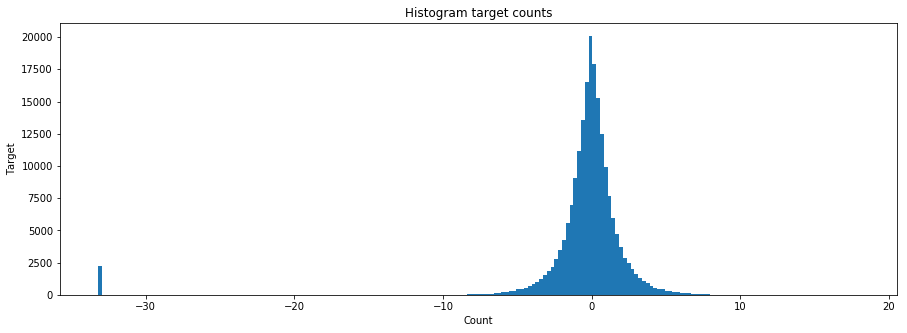

In [6]:
plt.figure(figsize=(15, 5))
plt.hist(train.target.values, bins=200)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

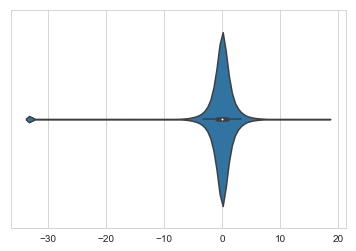

In [7]:
sns.set_style("whitegrid")
ax = sns.violinplot(x=train.target.values)
plt.show()

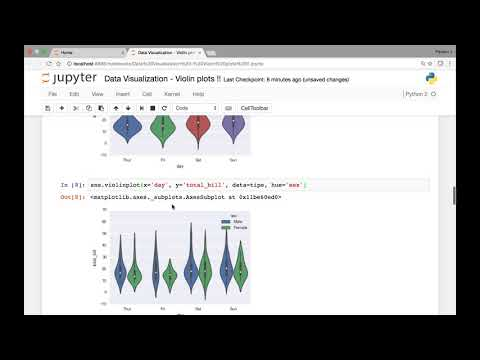

In [8]:
YouTubeVideo('txps4BtYOJE')

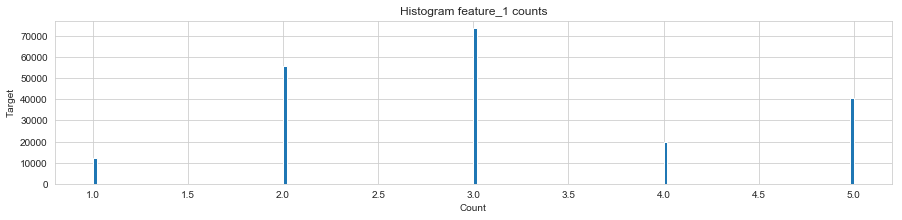

In [9]:
plt.figure(figsize=(15, 3))
plt.hist(train.feature_1.values, bins=200)
plt.title('Histogram feature_1 counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

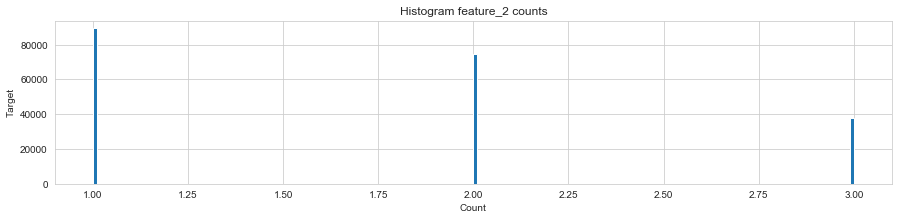

In [10]:
plt.figure(figsize=(15, 3))
plt.hist(train.feature_2.values, bins=200)
plt.title('Histogram feature_2 counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

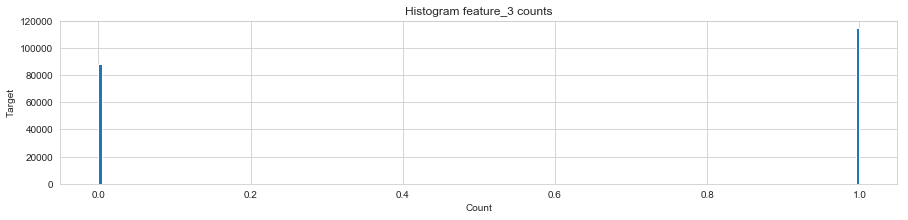

In [11]:
plt.figure(figsize=(15, 3))
plt.hist(train.feature_3.values, bins=200)
plt.title('Histogram feature_3 counts')
plt.xlabel('Count')
plt.ylabel('Target')
plt.show()

In [12]:
train['first_active_month'] = pd.to_datetime(train['first_active_month'])
test['first_active_month'] = pd.to_datetime(test['first_active_month'])
train['elapsed_time'] = (datetime.date(2018, 2, 1) - train['first_active_month'].dt.date).dt.days
test['elapsed_time'] = (datetime.date(2018, 2, 1) - test['first_active_month'].dt.date).dt.days

train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1

target = train['target']
del train['target']

train[:3]

,first_active_month,card_id,feature_1,feature_2,feature_3,elapsed_time,outliers
0,2017-06-01,C_ID_92a2005557,5,2,1,245,0
1,2017-01-01,C_ID_3d0044924f,4,1,0,396,0
2,2016-08-01,C_ID_d639edf6cd,2,2,0,549,0


In [13]:
new_transactions = pd.read_csv('input/new_merchant_transactions.csv', parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('input/historical_transactions.csv', parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [14]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

agg_fun = {'authorized_flag': ['sum', 'mean']}
auth_mean = historical_transactions.groupby(['card_id']).agg(agg_fun)
auth_mean.columns = ['_'.join(col).strip() for col in auth_mean.columns.values]
auth_mean.reset_index(inplace=True)

authorized_transactions = historical_transactions[historical_transactions['authorized_flag'] == 1]
historical_transactions = historical_transactions[historical_transactions['authorized_flag'] == 0]

Memory usage decreased to 1304.89 Mb (54.8% reduction)
Memory usage decreased to 84.24 Mb (56.7% reduction)


In [15]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
authorized_transactions['purchase_month'] = authorized_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

In [16]:
def aggregate_transactions(history):
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).astype(np.int64) * 1e-9

    agg_func = {
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp, 'min', 'max'],
        'month_lag': ['min', 'max']
        }

    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)

    df = (history.groupby('card_id').size().reset_index(name='transactions_count'))
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')

    return agg_history

In [17]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

,card_id,hist_transactions_count,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,hist_category_2_5.0_mean,hist_category_3_A_mean,...,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_purchase_date_min,hist_purchase_date_max,hist_month_lag_min,hist_month_lag_max
0,C_ID_00007093c1,35,4.0,0.114286,0.000000,0.000000,0.885714,0.0,0.000000,0.000000,...,0.667367,5.914286,12,1,3.071419,28858113.0,1.489250e+09,1.518108e+09,-11,0
1,C_ID_0001238066,3,0.0,0.000000,0.333333,0.000000,0.000000,0.0,0.666667,0.000000,...,0.000000,8.666667,12,2,5.773503,3609150.0,1.514660e+09,1.518269e+09,-2,0
2,C_ID_0001506ef0,4,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.750000,...,0.500000,5.500000,12,2,4.725816,22098875.0,1.496772e+09,1.518871e+09,-8,0
3,C_ID_0001793786,27,2.0,0.074074,0.111111,0.296296,0.111111,0.0,0.000000,0.814815,...,0.395847,6.481481,9,3,2.375684,16780236.0,1.488636e+09,1.505416e+09,-7,-1
4,C_ID_000183fdda,7,0.0,0.000000,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,...,2.288689,8.285714,10,8,0.755929,6701589.0,1.502099e+09,1.508801e+09,-6,-4


In [18]:
authorized = aggregate_transactions(authorized_transactions)
authorized.columns = ['auth_' + c if c != 'card_id' else c for c in authorized.columns]
authorized[:5]

,card_id,auth_transactions_count,auth_category_1_sum,auth_category_1_mean,auth_category_2_1.0_mean,auth_category_2_2.0_mean,auth_category_2_3.0_mean,auth_category_2_4.0_mean,auth_category_2_5.0_mean,auth_category_3_A_mean,...,auth_installments_std,auth_purchase_month_mean,auth_purchase_month_max,auth_purchase_month_min,auth_purchase_month_std,auth_purchase_date_ptp,auth_purchase_date_min,auth_purchase_date_max,auth_month_lag_min,auth_month_lag_max
0,C_ID_00007093c1,114,24.0,0.210526,0.000000,0.000000,0.780702,0.0,0.008772,0.0,...,0.795159,6.517544,12,1,3.371490,32627654.0,1.487081e+09,1.519708e+09,-12,0
1,C_ID_0001238066,120,2.0,0.016667,0.783333,0.000000,0.000000,0.0,0.150000,0.0,...,1.501050,7.275000,12,1,4.895483,13110825.0,1.506638e+09,1.519748e+09,-5,0
2,C_ID_0001506ef0,62,0.0,0.000000,0.032258,0.000000,0.967742,0.0,0.000000,1.0,...,0.000000,6.887097,12,1,4.538017,34460275.0,1.484411e+09,1.518871e+09,-13,0
3,C_ID_0001793786,189,0.0,0.000000,0.042328,0.359788,0.063492,0.0,0.000000,1.0,...,0.000000,6.698413,10,1,2.301491,24487497.0,1.484994e+09,1.509481e+09,-9,0
4,C_ID_000183fdda,137,4.0,0.029197,0.051095,0.007299,0.905109,0.0,0.007299,0.0,...,2.108912,6.810219,12,1,4.538289,15148616.0,1.504444e+09,1.519592e+09,-5,0


In [19]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,new_category_2_5.0_mean,new_category_3_A_mean,...,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_purchase_date_min,new_purchase_date_max,new_month_lag_min,new_month_lag_max
0,C_ID_00007093c1,2,0,0.000000,0.500000,0.000000,0.50000,0.0,0.000000,0.0,...,0.000000,4.000000,4,4,0.000000,537024.0,1.522754e+09,1.523291e+09,2,2
1,C_ID_0001238066,26,2,0.076923,0.769231,0.000000,0.00000,0.0,0.115385,0.0,...,2.079941,3.346154,4,3,0.485165,5195343.0,1.519923e+09,1.525118e+09,1,2
2,C_ID_0001506ef0,2,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,1.0,...,0.000000,3.000000,3,3,0.000000,471152.0,1.521239e+09,1.521710e+09,1,1
3,C_ID_0001793786,31,0,0.000000,0.483871,0.258065,0.16129,0.0,0.032258,1.0,...,0.000000,11.322581,12,11,0.475191,3981096.0,1.510761e+09,1.514742e+09,1,2
4,C_ID_000183fdda,11,0,0.000000,0.000000,0.000000,1.00000,0.0,0.000000,0.0,...,1.293340,3.272727,4,3,0.467099,5106807.0,1.519994e+09,1.525100e+09,1,2


In [20]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
            'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
            }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

final_group =  aggregate_per_month(historical_transactions) 
final_group[:10]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,...,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-5.500000,3.605551,2.916667,1.621354,-1.200164,0.999049,-0.431906,0.260478,-0.613764,...,3.750000,3.107908,1.176389,0.326634,1.000000,0.000000,1.500000,0.797724,0.355262,0.480551
1,C_ID_0001238066,-1.000000,1.414214,1.500000,0.707107,-0.894964,0.421890,-0.596643,0.000000,-0.596643,...,1.500000,0.707107,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,NaN
2,C_ID_0001506ef0,-3.333333,4.163332,1.333333,0.577350,-0.968594,0.395645,-0.731020,0.015849,-0.732397,...,0.333333,0.577350,0.166667,0.288675,0.000000,0.000000,0.333333,0.577350,0.707107,NaN
3,C_ID_0001793786,-3.833333,2.316607,4.500000,1.974842,-1.970890,2.037261,-0.423501,0.392159,-0.676499,...,0.833333,0.983192,0.291667,0.400520,0.166667,0.408248,0.500000,0.547723,0.179558,0.279244
4,C_ID_000183fdda,-5.000000,1.414214,3.500000,3.535534,-0.470690,0.344856,-0.376174,0.478523,-0.579708,...,9.500000,12.020815,2.000000,1.414214,1.000000,0.000000,3.500000,3.535534,2.366432,NaN
5,C_ID_00024e244b,-5.000000,4.000000,2.428571,1.397276,-1.186659,1.210810,-0.558085,0.326273,-0.607249,...,0.714286,1.112697,0.297619,0.419041,0.142857,0.377964,0.428571,0.534522,0.269338,0.312603
6,C_ID_0002709b5a,-7.250000,5.057997,1.500000,1.000000,-0.929675,0.699316,-0.604163,0.156637,-0.616865,...,2.750000,2.362908,2.250000,2.500000,2.250000,2.500000,2.250000,2.500000,0.000000,NaN
7,C_ID_00027503e2,-4.000000,2.915476,3.600000,1.516575,-2.669652,1.128393,-0.741249,0.002457,-0.742989,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-6.500000,3.535534,1.000000,0.000000,-0.617958,0.093896,-0.617958,0.093896,-0.617958,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
9,C_ID_0002ba3c2e,-3.666667,3.559026,2.500000,1.516575,-1.547448,0.910264,-0.641704,0.080430,-0.655965,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, authorized, on='card_id', how='left')
test = pd.merge(test, authorized, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id', how='left')
test = pd.merge(test, final_group, on='card_id', how='left')

train = pd.merge(train, auth_mean, on='card_id', how='left')
test = pd.merge(test, auth_mean, on='card_id', how='left')

In [22]:
features = [c for c in train.columns if c not in ['card_id', 'first_active_month', 'outliers']]
categorical_feats = [c for c in features if 'feature_' in c]

In [23]:
print(train.shape)
print(test.shape)

(201917, 140)
(123623, 139)


In [ ]:
YouTubeVideo('Q81RR3yKn30')

In [24]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)
target.to_csv('target.csv', index=False)

In [19]:
oof_ridge = np.zeros(train.shape[0])
predictions_ridge = np.zeros(test.shape[0])

tst_data = test.copy()
tst_data.fillna((tst_data.mean()), inplace=True)

tst_data = tst_data[features].values

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):
    print("fold n°{}".format(fold_+1))
    trn_data, trn_y = train.iloc[trn_idx][features], target.iloc[trn_idx].values
    val_data, val_y = train.iloc[val_idx][features], target.iloc[val_idx].values
    
    trn_data.fillna((trn_data.mean()), inplace=True)
    val_data.fillna((val_data.mean()), inplace=True)
    
    trn_data = trn_data.values
    val_data = val_data.values

    clf = Ridge(alpha=100)
    clf.fit(trn_data, trn_y)
    
    oof_ridge[val_idx] = clf.predict(val_data)
    predictions_ridge += clf.predict(tst_data) / folds.n_splits

np.save('oof_ridge', oof_ridge)
np.save('predictions_ridge', predictions_ridge)
np.sqrt(mean_squared_error(target.values, oof_ridge))

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


6.242135828278894

In [26]:
del tst_data
gc.collect()

14

In [21]:
param = {'num_leaves': 120,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "min_child_samples": 30,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):    
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds=200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    
np.save('oof_lgb', oof_lgb)
np.save('predictions_lgb', predictions_lgb)
np.sqrt(mean_squared_error(target.values, oof_lgb))

-
Fold 1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.68914	valid_1's rmse: 3.76622
[200]	training's rmse: 3.58367	valid_1's rmse: 3.72821
[300]	training's rmse: 3.50455	valid_1's rmse: 3.71019
[400]	training's rmse: 3.44063	valid_1's rmse: 3.69964
[500]	training's rmse: 3.38609	valid_1's rmse: 3.6944
[600]	training's rmse: 3.33922	valid_1's rmse: 3.69065
[700]	training's rmse: 3.29741	valid_1's rmse: 3.68806
[800]	training's rmse: 3.26035	valid_1's rmse: 3.68682
[900]	training's rmse: 3.22612	valid_1's rmse: 3.68602
[1000]	training's rmse: 3.19371	valid_1's rmse: 3.68576
[1100]	training's rmse: 3.16404	valid_1's rmse: 3.68539
[1200]	training's rmse: 3.13545	valid_1's rmse: 3.68507
[1300]	training's rmse: 3.10946	valid_1's rmse: 3.68488
[1400]	training's rmse: 3.08401	valid_1's rmse: 3.68544
Early stopping, best iteration is:
[1273]	training's rmse: 3.11628	valid_1's rmse: 3.68478
-
Fold 2
Training until validation scores don't improve for 200

3.678845579885177

In [28]:
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True}

oof_xgb = np.zeros(len(train))
predictions_xgb = np.zeros(len(test))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = xgb.DMatrix(data=train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train.iloc[val_idx][features], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 10000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx][features]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb += xgb_model.predict(xgb.DMatrix(test[features]), ntree_limit=xgb_model.best_ntree_limit+50) / folds.n_splits
    
np.save('oof_xgb', oof_xgb)
np.save('predictions_xgb', predictions_xgb)
np.sqrt(mean_squared_error(target.values, oof_xgb))

-
Fold 1
xgb 0--------------------------------------------------
[0]	train-rmse:3.94755	valid-rmse:3.95424
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[794]	train-rmse:2.82147	valid-rmse:3.68405

-
Fold 2
xgb 1--------------------------------------------------
[0]	train-rmse:3.94771	valid-rmse:3.95356
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1000]	train-rmse:2.72605	valid-rmse:3.66904
Stopping. Best iteration:
[1134]	train-rmse:2.67392	valid-rmse:3.66816

-
Fold 3
xgb 2--------------------------------------------------
[0]	train-rmse:3.95071	valid-rmse:3.94161
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1000]	train-rmse:2.73426	valid-rmse:3.66018
Stopping. B

3.673924616556465

In [29]:
del train, test
gc.collect()

63

In [8]:
new_transactions = pd.read_csv('input/new_merchant_transactions.csv', parse_dates=['purchase_date'])
historical_transactions = pd.read_csv('input/historical_transactions.csv', parse_dates=['purchase_date'])

def binarize(df):
    for col in ['authorized_flag', 'category_1']:
        df[col] = df[col].map({'Y':1, 'N':0})
    return df

historical_transactions = binarize(historical_transactions)
new_transactions = binarize(new_transactions)

In [9]:
def read_data(input_file):
    df = pd.read_csv(input_file)
    df['first_active_month'] = pd.to_datetime(df['first_active_month'])
    df['elapsed_time'] = (datetime.date(2018, 2, 1) - df['first_active_month'].dt.date).dt.days
    return df

train = read_data('input/train.csv')
test = read_data('input/test.csv')

train['outliers'] = 0
train.loc[train['target'] < -30, 'outliers'] = 1

target = train['target']
del train['target']

In [10]:
historical_transactions = pd.get_dummies(historical_transactions, columns=['category_2', 'category_3'])
new_transactions = pd.get_dummies(new_transactions, columns=['category_2', 'category_3'])

historical_transactions = reduce_mem_usage(historical_transactions)
new_transactions = reduce_mem_usage(new_transactions)

Memory usage decreased to 1304.89 Mb (54.8% reduction)
Memory usage decreased to 84.24 Mb (56.7% reduction)


In [11]:
historical_transactions['purchase_month'] = historical_transactions['purchase_date'].dt.month
new_transactions['purchase_month'] = new_transactions['purchase_date'].dt.month

def aggregate_transactions(history):
    history.loc[:, 'purchase_date'] = pd.DatetimeIndex(history['purchase_date']).astype(np.int64) * 1e-9
    
    agg_func = {
        'authorized_flag': ['sum', 'mean'],
        'category_1': ['sum', 'mean'],
        'category_2_1.0': ['mean'],
        'category_2_2.0': ['mean'],
        'category_2_3.0': ['mean'],
        'category_2_4.0': ['mean'],
        'category_2_5.0': ['mean'],
        'category_3_A': ['mean'],
        'category_3_B': ['mean'],
        'category_3_C': ['mean'],
        'merchant_id': ['nunique'],
        'merchant_category_id': ['nunique'],
        'state_id': ['nunique'],
        'city_id': ['nunique'],
        'subsector_id': ['nunique'],
        'purchase_amount': ['sum', 'mean', 'max', 'min', 'std'],
        'installments': ['sum', 'mean', 'max', 'min', 'std'],
        'purchase_month': ['mean', 'max', 'min', 'std'],
        'purchase_date': [np.ptp],
        'month_lag': ['min', 'max']
        }
    
    agg_history = history.groupby(['card_id']).agg(agg_func)
    agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
    agg_history.reset_index(inplace=True)
    
    df = (history.groupby('card_id')
          .size()
          .reset_index(name='transactions_count'))
    
    agg_history = pd.merge(df, agg_history, on='card_id', how='left')
    
    return agg_history

In [12]:
history = aggregate_transactions(historical_transactions)
history.columns = ['hist_' + c if c != 'card_id' else c for c in history.columns]
history[:5]

,card_id,hist_transactions_count,hist_authorized_flag_sum,hist_authorized_flag_mean,hist_category_1_sum,hist_category_1_mean,hist_category_2_1.0_mean,hist_category_2_2.0_mean,hist_category_2_3.0_mean,hist_category_2_4.0_mean,...,hist_installments_max,hist_installments_min,hist_installments_std,hist_purchase_month_mean,hist_purchase_month_max,hist_purchase_month_min,hist_purchase_month_std,hist_purchase_date_ptp,hist_month_lag_min,hist_month_lag_max
0,C_ID_00007093c1,149,114.0,0.765101,28.0,0.187919,0.000000,0.000000,0.805369,0.0,...,6,1,0.764900,6.375839,12,1,3.303308,32627654.0,-12,0
1,C_ID_0001238066,123,120.0,0.975610,2.0,0.016260,0.772358,0.000000,0.000000,0.0,...,10,-1,1.485637,7.308943,12,1,4.895850,13110825.0,-5,0
2,C_ID_0001506ef0,66,62.0,0.939394,0.0,0.000000,0.030303,0.000000,0.969697,0.0,...,1,0,0.123091,6.803030,12,1,4.524190,34460275.0,-13,0
3,C_ID_0001793786,216,189.0,0.875000,2.0,0.009259,0.050926,0.351852,0.069444,0.0,...,1,0,0.150723,6.671296,10,1,2.306373,24487497.0,-9,0
4,C_ID_000183fdda,144,137.0,0.951389,4.0,0.027778,0.048611,0.006944,0.909722,0.0,...,10,-1,2.118846,6.881944,12,1,4.439959,17492874.0,-6,0


In [13]:
new = aggregate_transactions(new_transactions)
new.columns = ['new_' + c if c != 'card_id' else c for c in new.columns]
new[:5]

,card_id,new_transactions_count,new_authorized_flag_sum,new_authorized_flag_mean,new_category_1_sum,new_category_1_mean,new_category_2_1.0_mean,new_category_2_2.0_mean,new_category_2_3.0_mean,new_category_2_4.0_mean,...,new_installments_max,new_installments_min,new_installments_std,new_purchase_month_mean,new_purchase_month_max,new_purchase_month_min,new_purchase_month_std,new_purchase_date_ptp,new_month_lag_min,new_month_lag_max
0,C_ID_00007093c1,2,2,1,0,0.000000,0.500000,0.000000,0.50000,0.0,...,1,1,0.000000,4.000000,4,4,0.000000,537024.0,2,2
1,C_ID_0001238066,26,26,1,2,0.076923,0.769231,0.000000,0.00000,0.0,...,10,-1,2.079941,3.346154,4,3,0.485165,5195343.0,1,2
2,C_ID_0001506ef0,2,2,1,0,0.000000,0.000000,0.000000,1.00000,0.0,...,0,0,0.000000,3.000000,3,3,0.000000,471152.0,1,1
3,C_ID_0001793786,31,31,1,0,0.000000,0.483871,0.258065,0.16129,0.0,...,0,0,0.000000,11.322581,12,11,0.475191,3981096.0,1,2
4,C_ID_000183fdda,11,11,1,0,0.000000,0.000000,0.000000,1.00000,0.0,...,4,-1,1.293340,3.272727,4,3,0.467099,5106807.0,1,2


In [14]:
def aggregate_per_month(history):
    grouped = history.groupby(['card_id', 'month_lag'])

    agg_func = {
        'purchase_amount': ['count', 'sum', 'mean', 'min', 'max', 'std'],
        'installments': ['count', 'sum', 'mean', 'min', 'max', 'std'],
    }

    intermediate_group = grouped.agg(agg_func)
    intermediate_group.columns = ['_'.join(col).strip() for col in intermediate_group.columns.values]
    intermediate_group.reset_index(inplace=True)

    final_group = intermediate_group.groupby('card_id').agg(['mean', 'std'])
    final_group.columns = ['_'.join(col).strip() for col in final_group.columns.values]
    final_group.reset_index(inplace=True)
    
    return final_group

final_group =  aggregate_per_month(historical_transactions) 
final_group[:10]

,card_id,month_lag_mean,month_lag_std,purchase_amount_count_mean,purchase_amount_count_std,purchase_amount_sum_mean,purchase_amount_sum_std,purchase_amount_mean_mean,purchase_amount_mean_std,purchase_amount_min_mean,...,installments_sum_mean,installments_sum_std,installments_mean_mean,installments_mean_std,installments_min_mean,installments_min_std,installments_max_mean,installments_max_std,installments_std_mean,installments_std_std
0,C_ID_00007093c1,-6.000000,3.894440,11.461538,4.701336,-5.911157,2.767303,-0.507947,0.097299,-0.704152,...,14.769231,6.431094,1.348480,0.357031,1.000000,0.000000,2.615385,1.556624,0.625616,0.609378
1,C_ID_0001238066,-2.500000,1.870829,20.500000,12.275993,-12.074533,7.033955,-0.603204,0.045861,-0.730351,...,33.000000,25.226970,1.639345,0.395889,0.666667,0.816497,4.666667,2.875181,1.246996,0.507930
2,C_ID_0001506ef0,-6.230769,4.225988,5.076923,4.536179,-2.661683,3.008707,-0.461749,0.259737,-0.725724,...,0.076923,0.277350,0.012821,0.046225,0.000000,0.000000,0.076923,0.277350,0.034021,0.117851
3,C_ID_0001793786,-4.500000,3.027650,21.600000,13.969809,-3.678601,4.769788,-0.042211,0.277565,-0.647028,...,0.500000,0.849837,0.014621,0.024394,0.000000,0.000000,0.300000,0.483046,0.065065,0.105721
4,C_ID_000183fdda,-3.000000,2.160247,20.571429,9.198861,-9.833991,6.162143,-0.425378,0.214361,-0.687901,...,37.714286,15.445758,1.998522,0.553938,0.428571,0.975900,8.714286,2.214670,2.173750,0.618504
5,C_ID_00024e244b,-6.384615,4.330867,5.384615,5.140338,-3.196366,1.920145,-0.675492,0.102732,-0.728885,...,0.384615,0.869718,0.086813,0.176941,0.000000,0.000000,0.230769,0.438529,0.140737,0.260774
6,C_ID_0002709b5a,-5.666667,3.915780,6.083333,3.752777,-3.971629,2.569685,-0.638997,0.067811,-0.699450,...,10.750000,9.284640,1.834061,1.170877,0.833333,0.577350,3.583333,3.287949,1.467005,1.520248
7,C_ID_00027503e2,-4.000000,2.738613,4.666667,2.449490,-3.458116,1.817940,-0.740950,0.001935,-0.743507,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,C_ID_000298032a,-5.111111,4.075673,3.333333,1.870829,-1.776935,0.845111,-0.586543,0.158033,-0.671617,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,C_ID_0002ba3c2e,-4.000000,3.366502,10.000000,6.403124,-6.334713,4.214750,-0.620432,0.063285,-0.690788,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
train = pd.merge(train, history, on='card_id', how='left')
test = pd.merge(test, history, on='card_id', how='left')

train = pd.merge(train, new, on='card_id', how='left')
test = pd.merge(test, new, on='card_id', how='left')

train = pd.merge(train, final_group, on='card_id')
test = pd.merge(test, final_group, on='card_id')

features = [c for c in train.columns if c not in ['card_id', 'first_active_month', 'outliers']]
categorical_feats = [c for c in features if 'feature_' in c]

In [16]:
param = {'num_leaves': 50,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.005,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1}

oof_lgb_2 = np.zeros(len(train))
predictions_lgb_2 = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):    
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx], categorical_feature=categorical_feats)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx], categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb_2[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions_lgb_2 += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits

np.save('oof_lgb_2', oof_lgb_2)
np.save('predictions_lgb_2', predictions_lgb_2)
print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb_2, target)**0.5))

fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 3.73719	valid_1's rmse: 3.77729
[200]	training's rmse: 3.66751	valid_1's rmse: 3.74176
[300]	training's rmse: 3.61611	valid_1's rmse: 3.72253
[400]	training's rmse: 3.57385	valid_1's rmse: 3.70951
[500]	training's rmse: 3.5385	valid_1's rmse: 3.7019
[600]	training's rmse: 3.5089	valid_1's rmse: 3.69677
[700]	training's rmse: 3.4832	valid_1's rmse: 3.69304
[800]	training's rmse: 3.46001	valid_1's rmse: 3.69038
[900]	training's rmse: 3.43807	valid_1's rmse: 3.68795
[1000]	training's rmse: 3.41871	valid_1's rmse: 3.68642
[1100]	training's rmse: 3.4004	valid_1's rmse: 3.68517
[1200]	training's rmse: 3.38372	valid_1's rmse: 3.68395
[1300]	training's rmse: 3.36763	valid_1's rmse: 3.68318
[1400]	training's rmse: 3.35261	valid_1's rmse: 3.68261
[1500]	training's rmse: 3.33797	valid_1's rmse: 3.68223
[1600]	training's rmse: 3.32425	valid_1's rmse: 3.68172
[1700]	training's rmse: 3.31067	valid_1's rmse

In [17]:
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8, 
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True}

oof_xgb_2 = np.zeros(len(train))
predictions_xgb_2 = np.zeros(len(test))

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train,train['outliers'].values)):    
    print('-')
    print("Fold {}".format(fold_ + 1))
    trn_data = xgb.DMatrix(data=train.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = xgb.DMatrix(data=train.iloc[val_idx][features], label=target.iloc[val_idx])
    watchlist = [(trn_data, 'train'), (val_data, 'valid')]
    print("xgb " + str(fold_) + "-" * 50)
    num_round = 10000
    xgb_model = xgb.train(xgb_params, trn_data, num_round, watchlist, early_stopping_rounds=50, verbose_eval=1000)
    oof_xgb_2[val_idx] = xgb_model.predict(xgb.DMatrix(train.iloc[val_idx][features]), ntree_limit=xgb_model.best_ntree_limit+50)

    predictions_xgb_2 += xgb_model.predict(xgb.DMatrix(test[features]), ntree_limit=xgb_model.best_ntree_limit+50) / folds.n_splits
    
np.save('oof_xgb_2', oof_xgb_2)
np.save('predictions_xgb_2', predictions_xgb_2)
np.sqrt(mean_squared_error(target.values, oof_xgb_2))

-
Fold 1
xgb 0--------------------------------------------------
[0]	train-rmse:3.94774	valid-rmse:3.95473
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[859]	train-rmse:2.81631	valid-rmse:3.68973

-
Fold 2
xgb 1--------------------------------------------------
[0]	train-rmse:3.94793	valid-rmse:3.95393
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[1000]	train-rmse:2.75753	valid-rmse:3.68205
Stopping. Best iteration:
[1095]	train-rmse:2.72327	valid-rmse:3.68149

-
Fold 3
xgb 2--------------------------------------------------
[0]	train-rmse:3.95087	valid-rmse:3.94181
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
Stopping. Best iteration:
[912]	train-rmse:2.79531	valid

3.682582931576429

In [22]:
train_stack = np.vstack([oof_ridge, oof_lgb, oof_xgb, oof_lgb_2, oof_xgb_2]).transpose()
test_stack = np.vstack([predictions_ridge, predictions_lgb, predictions_xgb,
                        predictions_lgb_2, predictions_xgb_2]).transpose()

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(train_stack.shape[0])
predictions = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_stack, train['outliers'].values)):
    print("fold n°{}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], target.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], target.iloc[val_idx].values

    clf = Ridge(alpha=1)
    clf.fit(trn_data, trn_y)
    
    oof[val_idx] = clf.predict(val_data)
    predictions += clf.predict(test_stack) / folds.n_splits


np.sqrt(mean_squared_error(target.values, oof))

NameError: name 'oof_xgb' is not defined